# Summary

Cleaning:
* Removed Purchase_Prod_ID, CustomerTier2, and Customer_ID as features since they would overfit the data.
* Removed ages under 18 and null values. 
* Changed categorical variables to dummy variables.
* Ensured that there wasn't multi-collinearity.

# Import Libraries and Data

In [164]:
import pandas as pd
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

In [165]:
df = pd.read_csv('train_data.csv')

In [166]:
df_test = pd.read_csv('test_data.csv')

In [167]:
df.head()

,Unnamed: 0,Rewards_Signup,Customer_ID,Age,Sex,Addtl_HH_size,CustomerType,LastPurchaseAmt,Purchase_Prod_ID,CustomerTier,CustomerTier2
0,0,1,67,29.0,female,0,New,10.5000,C.A. 29395,2,F33
1,1,1,40,14.0,female,1,Reactivated,11.2417,2651,3,NaN
2,2,1,45,19.0,female,0,Existing,7.8792,330958,3,NaN
3,3,0,87,16.0,male,4,New,34.3750,W./C. 6608,3,NaN
4,4,0,486,NaN,female,4,New,25.4667,4133,3,NaN


# EDA

In [168]:
df.describe()

,Unnamed: 0,Rewards_Signup,Customer_ID,Age,Addtl_HH_size,LastPurchaseAmt,CustomerTier
count,712.000000,712.000000,712.000000,580.000000,712.000000,712.000000,712.000000
mean,355.500000,0.386236,442.853933,29.487931,0.918539,33.270487,2.299157
std,205.680983,0.487228,252.897790,14.422576,1.624044,52.709774,0.839663
min,0.000000,0.000000,1.000000,0.420000,0.000000,0.000000,1.000000
25%,177.750000,0.000000,225.750000,20.875000,0.000000,7.925000,2.000000
50%,355.500000,0.000000,443.500000,28.000000,0.000000,14.454200,3.000000
75%,533.250000,1.000000,660.250000,37.000000,1.000000,31.275000,3.000000
max,711.000000,1.000000,889.000000,80.000000,10.000000,512.329200,3.000000


## Exploring Columns

In [169]:
df['Rewards_Signup'].value_counts()

0    437
1    275
Name: Rewards_Signup, dtype: int64

The rewards signup is the target, so these might need to be balanced. First I'll just be keeping track to precision and recall. If the classification models start being severely skewed toward predicting 0, I'll balance the classes.

In [170]:
print("There are ", len(df['Customer_ID'].unique()), "unique customer IDs")

There are  712 unique customer IDs


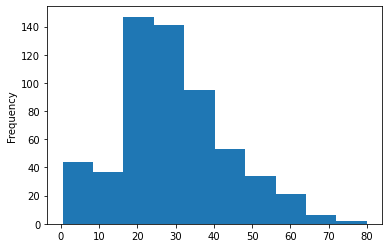

In [171]:
df['Age'].plot.hist()

In [172]:
len(df[df['Age'] < 18])

93

I'm assuming that inputs under 18 are mistakes, since to sign up for rewards programs customers typically have to be 18 and over. These values will be removed.

In [173]:
df['Sex'].value_counts()

male      460
female    252
Name: Sex, dtype: int64

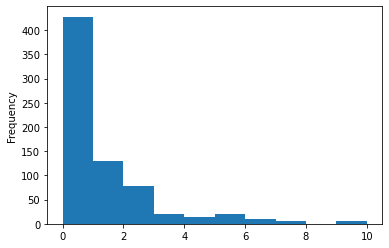

In [174]:
df['Addtl_HH_size'].plot.hist()

In [175]:
df['CustomerType'].value_counts()

New            518
Reactivated    134
Existing        58
Name: CustomerType, dtype: int64

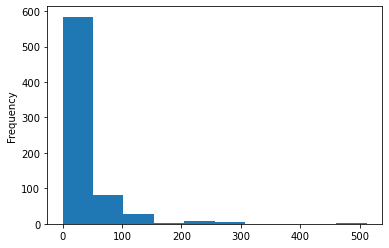

In [176]:
df['LastPurchaseAmt'].plot.hist()

In [177]:
df[df['LastPurchaseAmt'] > 400]

,Unnamed: 0,Rewards_Signup,Customer_ID,Age,Sex,Addtl_HH_size,CustomerType,LastPurchaseAmt,Purchase_Prod_ID,CustomerTier,CustomerTier2
58,58,1,259,35.0,female,0,Reactivated,512.3292,PC 17755,1,NaN
411,411,1,680,36.0,male,1,Reactivated,512.3292,PC 17755,1,B51 B53 B55
660,660,1,738,35.0,male,0,Reactivated,512.3292,PC 17755,1,B101


It's possible that the customers who spent over $400 in their last purchase are outliers. It should also be noted that they all bought the same thing. For now I'll keep them, since they are three different customers and since paying a significant amount could indicate that they're more likely to sign up for rewards.

In [178]:
print('There are ', len(df.Purchase_Prod_ID.unique()), 'unique product IDs')

There are  569 unique product IDs


This many unique values compared to total rows could lead to overfitting, so I'll be removing this row.

In [179]:
df['CustomerTier'].value_counts()

3    389
1    176
2    147
Name: CustomerTier, dtype: int64

In [180]:
print('There are', len(df['CustomerTier2'].unique()), 'unique CustomerTier2 values and', df['CustomerTier2'].isna().sum(), 'nan values.') 

There are 129 unique CustomerTier2 values and 546 nan values.


This many nan values and so many unique values will lead to overfitting and/or having to remove too many rows from the data set, so I won't be using CustomerTier2 as a feature.

# Cleaning

In [181]:
df.head()

,Unnamed: 0,Rewards_Signup,Customer_ID,Age,Sex,Addtl_HH_size,CustomerType,LastPurchaseAmt,Purchase_Prod_ID,CustomerTier,CustomerTier2
0,0,1,67,29.0,female,0,New,10.5000,C.A. 29395,2,F33
1,1,1,40,14.0,female,1,Reactivated,11.2417,2651,3,NaN
2,2,1,45,19.0,female,0,Existing,7.8792,330958,3,NaN
3,3,0,87,16.0,male,4,New,34.3750,W./C. 6608,3,NaN
4,4,0,486,NaN,female,4,New,25.4667,4133,3,NaN


## Make sure there are no repeat customer IDs

In [182]:
# Remove Customer ID duplicates from train data
df.drop_duplicates(subset='Customer_ID', keep='first', inplace=True)

# Remove Customer ID duplicates from test data
df_test.drop_duplicates(subset='Customer_ID', keep='first', inplace=True)

In [183]:
df.shape

(712, 11)

## Remove Unnecessary Columns

In [184]:
# Remove product ID column and customertier2 from train data.
df.drop(columns=['Unnamed: 0', 'Purchase_Prod_ID', 'CustomerTier2', 'Customer_ID'], inplace=True)

# Remove product ID column and customertier2 from test data.
df_test.drop(columns=['Unnamed: 0', 'Purchase_Prod_ID', 'CustomerTier2', 'Customer_ID'], inplace=True)

In [185]:
df.shape

(712, 7)

## Turn ages under 18 to nan, and then remove nan values

In [186]:
# Remove Age null values and Age values less than 18 from train data
df = df[df.Age > 17]

# Remove Age null values and Age values less than 18 from test data
df_test = df_test[df_test.Age > 17]

In [187]:
df.shape

(487, 7)

# Further EDA

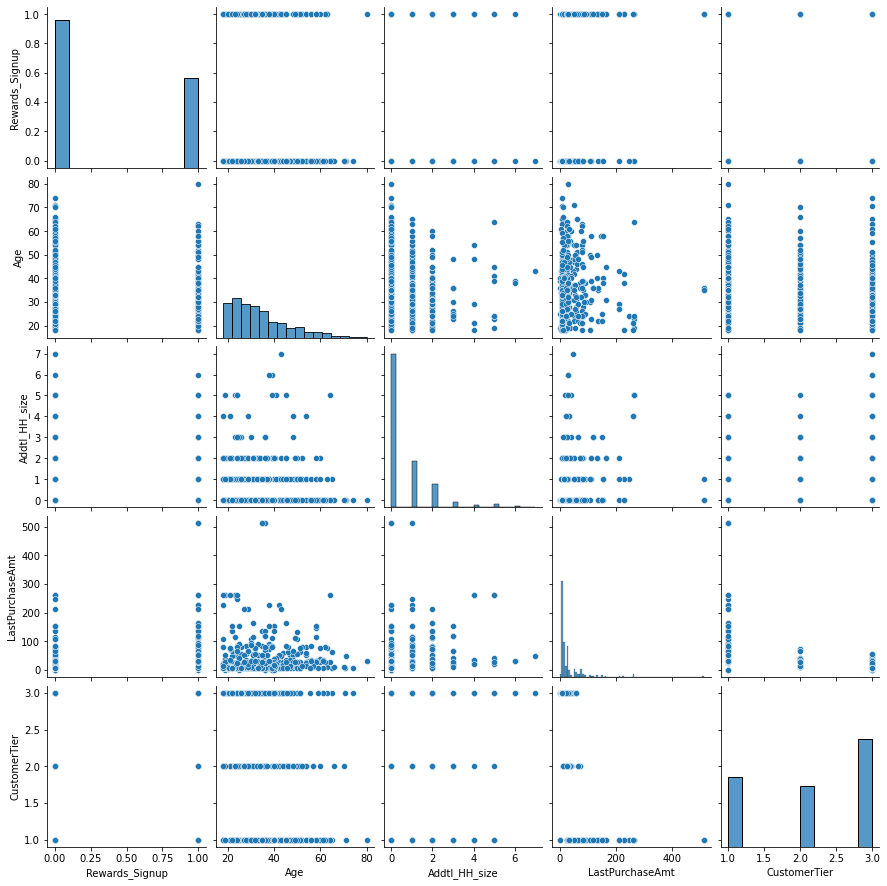

In [147]:
sns.pairplot(df)

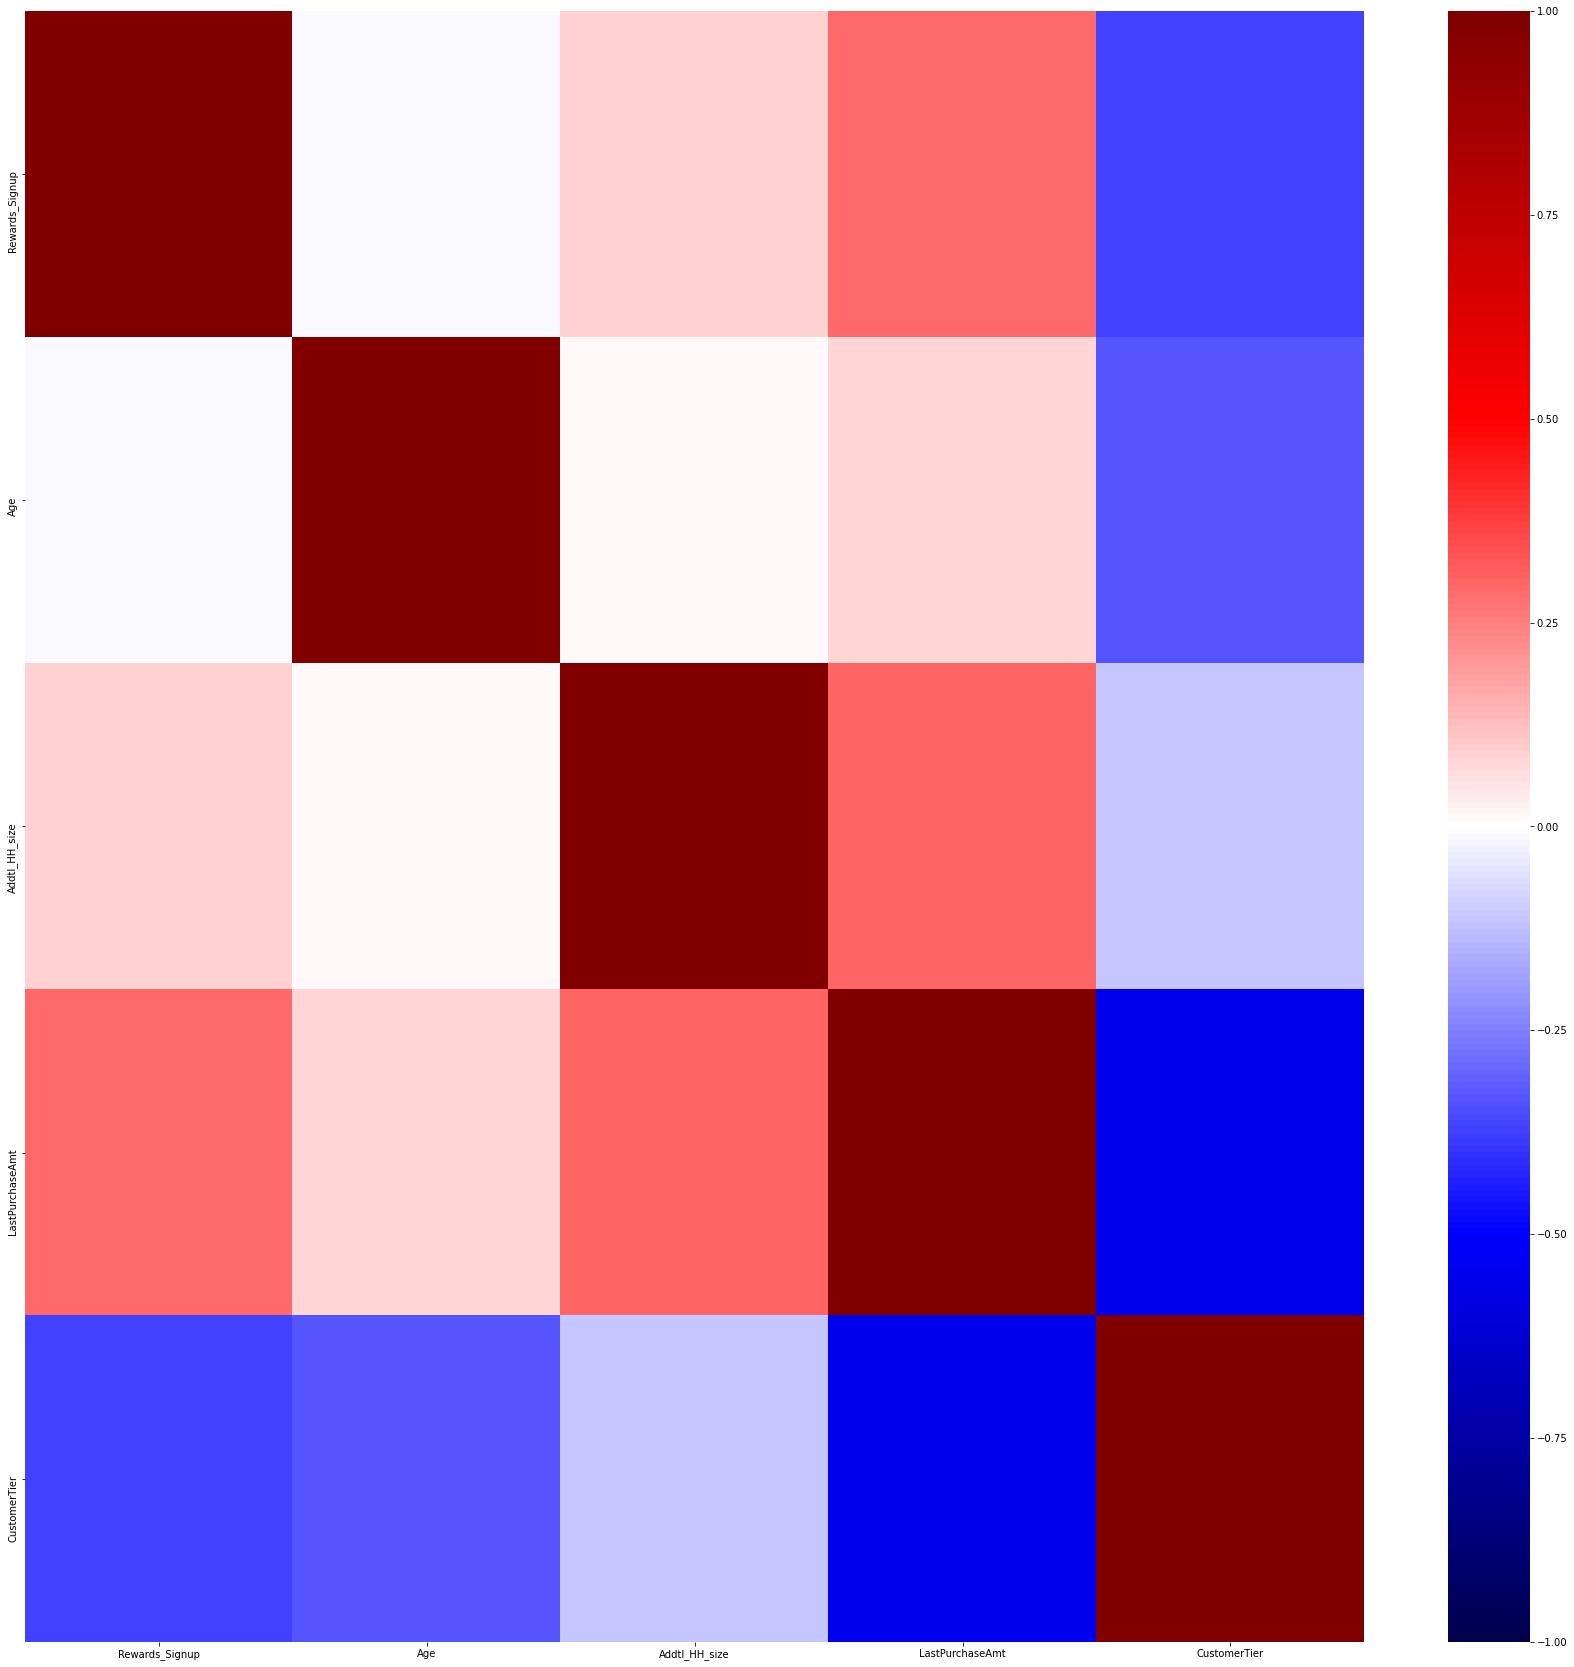

In [148]:
# Plot all correlations
fig, ax = plt.subplots(figsize=(30, 30))

sns.heatmap(df.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

plt.show()

To note: 
* The target is highly negatively correlated with the CustomerTier.
* The CustomerTier is highly negatively correlated with the target, Age, and LastPurchaseAmount (especially LastPurchaseAmount).

# Get Dummies Encoding

In [188]:
# Encode sex. Male = 1, and Female = 0.
df['Sex'] = pd.get_dummies(df.Sex, drop_first=True)

# Encode sex. Male = 1, and Female = 0.
df_test['Sex'] = pd.get_dummies(df_test.Sex, drop_first=True)

In [189]:
# Encode Customer Type. 0 and 0 in New and Reactivated indicates Existing
df['New'] = pd.get_dummies(df.CustomerType, drop_first=True).New

# Encode Customer Type. 0 and 0 in New and Reactivated indicates Existing
df_test['New'] = pd.get_dummies(df_test.CustomerType, drop_first=True).New

In [190]:
# Encode Customer Type. 0 and 0 in New and Reactivated indicates Existing
df['Reactivated'] = pd.get_dummies(df.CustomerType, drop_first=True).Reactivated

# Encode Customer Type. 0 and 0 in New and Reactivated indicates Existing
df_test['Reactivated'] = pd.get_dummies(df_test.CustomerType, drop_first=True).Reactivated

In [191]:
df.drop(columns=['CustomerType'], inplace=True)
df_test.drop(columns=['CustomerType'], inplace=True)

# VIF

VIF score of an independent variable represents how well the variable is explained by other independent variables.

In [192]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [193]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [194]:
X = df.iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,Rewards_Signup,2.148649
1,Age,5.803981
2,Sex,4.298033
3,Addtl_HH_size,1.594547
4,LastPurchaseAmt,1.889258
5,CustomerTier,6.158038
6,New,4.643150


None of these values are over ten, meaning there isn't any significant multi-collinearity. This was important to test because I'll be using a logistic regression model with the intention of interpreting its coefficients, and if the features contained multi-collinearity it would not be possible to accurately interpret the coefficients.

# Save cleaned data as new files

In [195]:
df.to_csv('train_df_cleaned.csv')
df_test.to_csv('test_df_cleaned.csv')

# Balance Classes

To balance the classes, I'm up-sampling the minority class. This artificially reduces the variance in the data, but down-sampling would remove too much data. 

In [157]:
from sklearn.utils import resample

In [158]:
df.head()

,Rewards_Signup,Age,Sex,Addtl_HH_size,LastPurchaseAmt,CustomerTier,New,Reactivated
0,1,29.0,0,0,10.5000,2,1,0
2,1,19.0,0,0,7.8792,3,0,0
6,0,25.0,1,0,7.0500,3,1,0
7,1,44.0,0,1,57.9792,1,0,1
8,1,32.0,1,0,7.9250,3,1,0


In [159]:
df.Rewards_Signup.value_counts()

0    302
1    185
Name: Rewards_Signup, dtype: int64

In [161]:
# Possibly need to do later
# Without balanced classes, the frequent cases 
# (not signing up for rewards) will be misclassified less frequently than the infrequent cases

df_majority = df[df.Rewards_Signup == 0]
df_minority = df[df.Rewards_Signup == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=302,    # to match majority class
                                 random_state=123) # reproducible results

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled.Rewards_Signup.value_counts()

1    302
0    302
Name: Rewards_Signup, dtype: int64

In [162]:
df = df_upsampled